## Exponential Duration Model
---


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
from IPython.display import display

The following cell generate data from

\begin{align*}
 & p(y_{i}|x_{1i},x_{2i}) = \frac1{\theta_{i}}e^{-\frac{y_{i}}{\theta_{i}}},\quad y_{i} > 0,\\
 & \theta_{i} =  \exp(0.5 x_{1i} - 0.5 x_{2i}),\quad i=1,\dots,500.
\end{align*}


In [2]:
n = 500
rng = np.random.default_rng(seed=99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n, random_state=rng)
the = np.exp(0.5*x1 - 0.5*x2)
y = st.expon.rvs(scale=the, random_state=rng)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [3]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
exponential_duration_model = pm.Model()
with exponential_duration_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Exponential('y', lam=pm.math.exp(-idx), observed=y)

In [4]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with exponential_duration_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng, nuts_sampler='numpyro', progressbar=False)
results = az.summary(trace, hdi_prob=0.95)
var_names = ['$\\beta_{:d}$'.format(index) for index in range(k)]
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].to_numpy()[:, :, index]) for index, var in enumerate(var_names)])

Compiling...
Compilation time = 0:00:01.022479
Sampling...
Sampling time = 0:00:02.037497
Transforming variables...
Transformation time = 0:00:00.067784


In [5]:
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\beta_0$,0.019,0.045,-0.066,0.110,0.0,0.0,19298.0,14565.0,1.0
$\beta_1$,0.496,0.045,0.408,0.583,0.0,0.0,19160.0,13381.0,1.0
$\beta_2$,-0.523,0.047,-0.617,-0.432,0.0,0.0,18899.0,13389.0,1.0


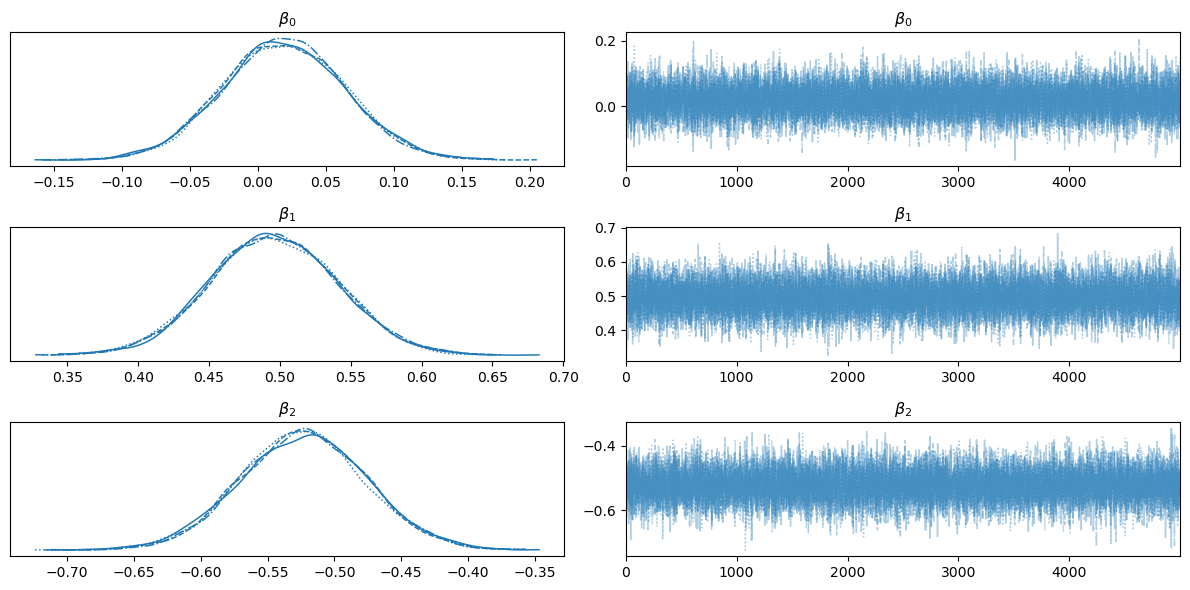

In [6]:
az.plot_trace(sim_param)
plt.tight_layout()
plt.show()

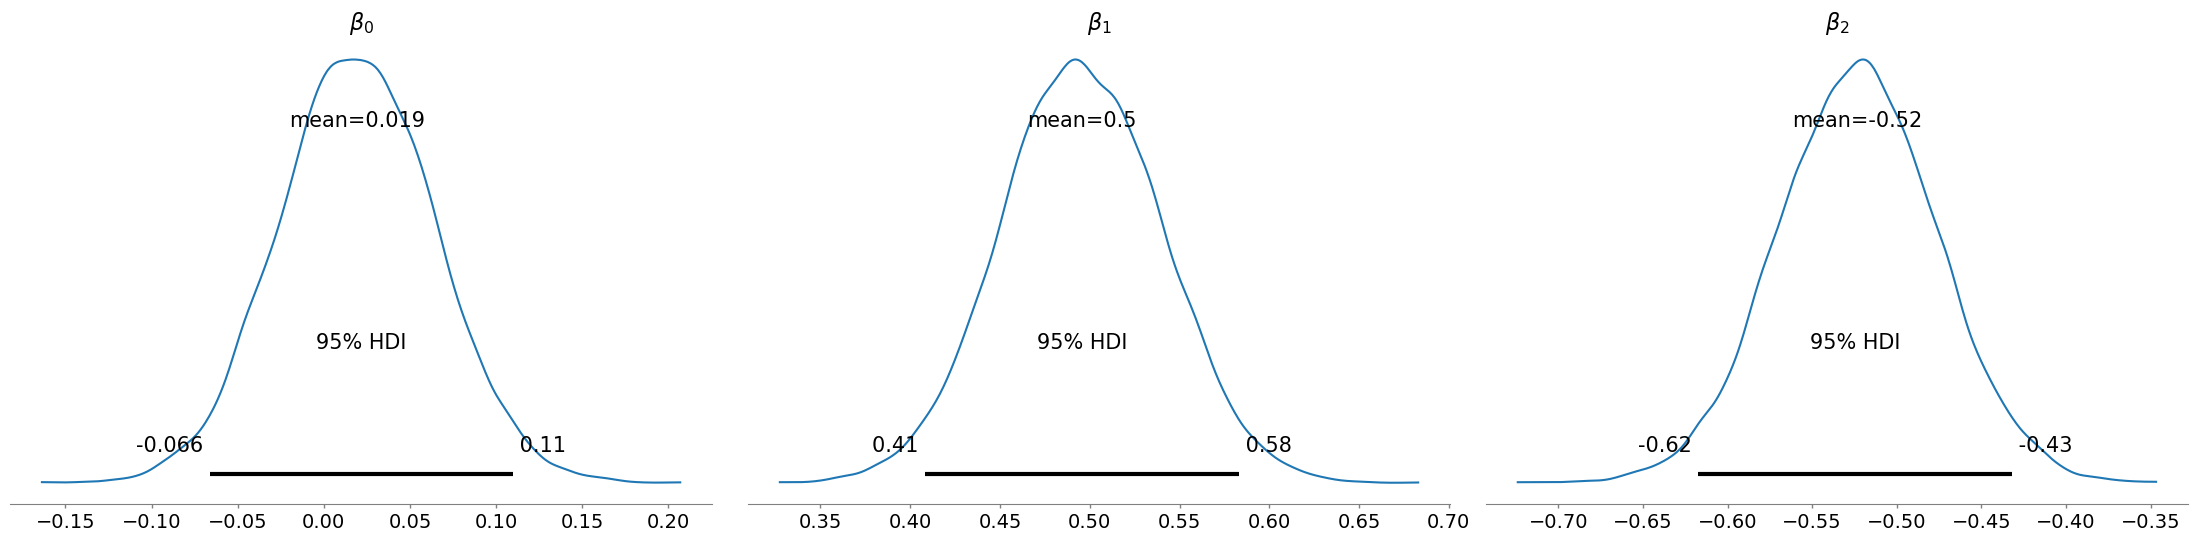

In [7]:
az.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()